# Role Discovery: Result Analysis

The primary objective is to compare the efficacy of two distinct approaches:

1.  **Traditional Method (`Feature-Based_Roles`)**: This method involves extracting a vector of structural features (e.g., centrality metrics, clustering coefficient) for each node and then applying K-Means clustering.
2.  **GNN-based Methods (`GNN_Embedder_GAE`, `GNN_Embedder_DGI`)**: These methods use an unsupervised Graph Neural Network (a Graph Autoencoder or Deep Graph Infomax model) to learn low-dimensional node embeddings. These embeddings, which capture the structural context of nodes, are then clustered using K-Means.

The analysis is performed on three datasets: **Cora**, **Actor**, and **CLUSTER**. We will evaluate the models based on internal clustering metrics and qualitative analysis, aiming to answer the following key questions:

  - Which method produces better-separated roles (clusters)?
  - How do we determine the optimal number of roles, $k$?
  - Can we assign meaningful, interpretable labels (e.g., "hub," "bridge," "periphery") to the discovered roles?


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style="whitegrid", palette="magma")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 12

RESULTS_DIR = Path("../results/role_discovery/")
DATASETS = ['Cora', 'Actor', 'CLUSTER']
MODELS = ["Feature-Based_Roles", "Feature-Based_Roles_Graphlets", "GNN_Embedder_GAE", "GNN_Embedder_DGI"]

print(f"Analysis Notebook Setup Complete.")
print(f"Results Directory: {RESULTS_DIR.resolve()}")
print(f"Datasets to Analyze: {DATASETS}")


Analysis Notebook Setup Complete.
Results Directory: /home/adriano/Desktop/network-science/project/results/role_discovery
Datasets to Analyze: ['Cora', 'Actor', 'CLUSTER']


## 1\. High-Level Comparison Across All Datasets


In [2]:
summary_path = RESULTS_DIR / "comparison_summary.csv"
if not summary_path.exists():
    print(f"Error: The summary file was not found at {summary_path}")
    print("Please run `python -m project.role_discovery.generate_report` first.")
    summary_df = pd.DataFrame()
else:
    summary_df = pd.read_csv(summary_path)

print("--- Overall Model Performance (based on best Silhouette Score) ---")
display(summary_df.style.format({
    'Silhouette Score': '{:.4f}',
    'Davies-Bouldin Index': '{:.4f}',
    'Calinski-Harabasz Index': '{:,.2f}'
}))

--- Overall Model Performance (based on best Silhouette Score) ---


,Dataset,Model,Best k,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,Cora,Feature-Based_Roles,7,0.4922,0.6659,"1,656.24"
1,Cora,GNN_Embedder_GAE,3,0.6056,0.5834,"4,116.95"
2,Cora,GNN_Embedder_DGI,3,0.6339,0.5306,"3,315.86"
3,Actor,Feature-Based_Roles,5,0.5061,0.6685,"7,224.95"
4,Actor,GNN_Embedder_GAE,3,0.7621,0.3459,"9,123.89"
5,Actor,GNN_Embedder_DGI,3,0.6952,0.5631,"6,426.50"
6,CLUSTER,Feature-Based_Roles,3,0.3698,0.8649,111.17
7,CLUSTER,GNN_Embedder_GAE,7,0.5613,0.4686,524.51
8,CLUSTER,GNN_Embedder_DGI,5,0.5578,0.4553,340.51


### 1.1. Visualizing Overall Performance

We will create a separate plot for each key metric.
  - **Silhouette Score**: Higher is better. Measures how similar a node is to its own role compared to other roles.
  - **Davies-Bouldin Index**: Lower is better. Measures the average similarity ratio of each role with its most similar one.
  - **Calinski-Harabasz Index**: Higher is better. The ratio of between-cluster dispersion to within-cluster dispersion.


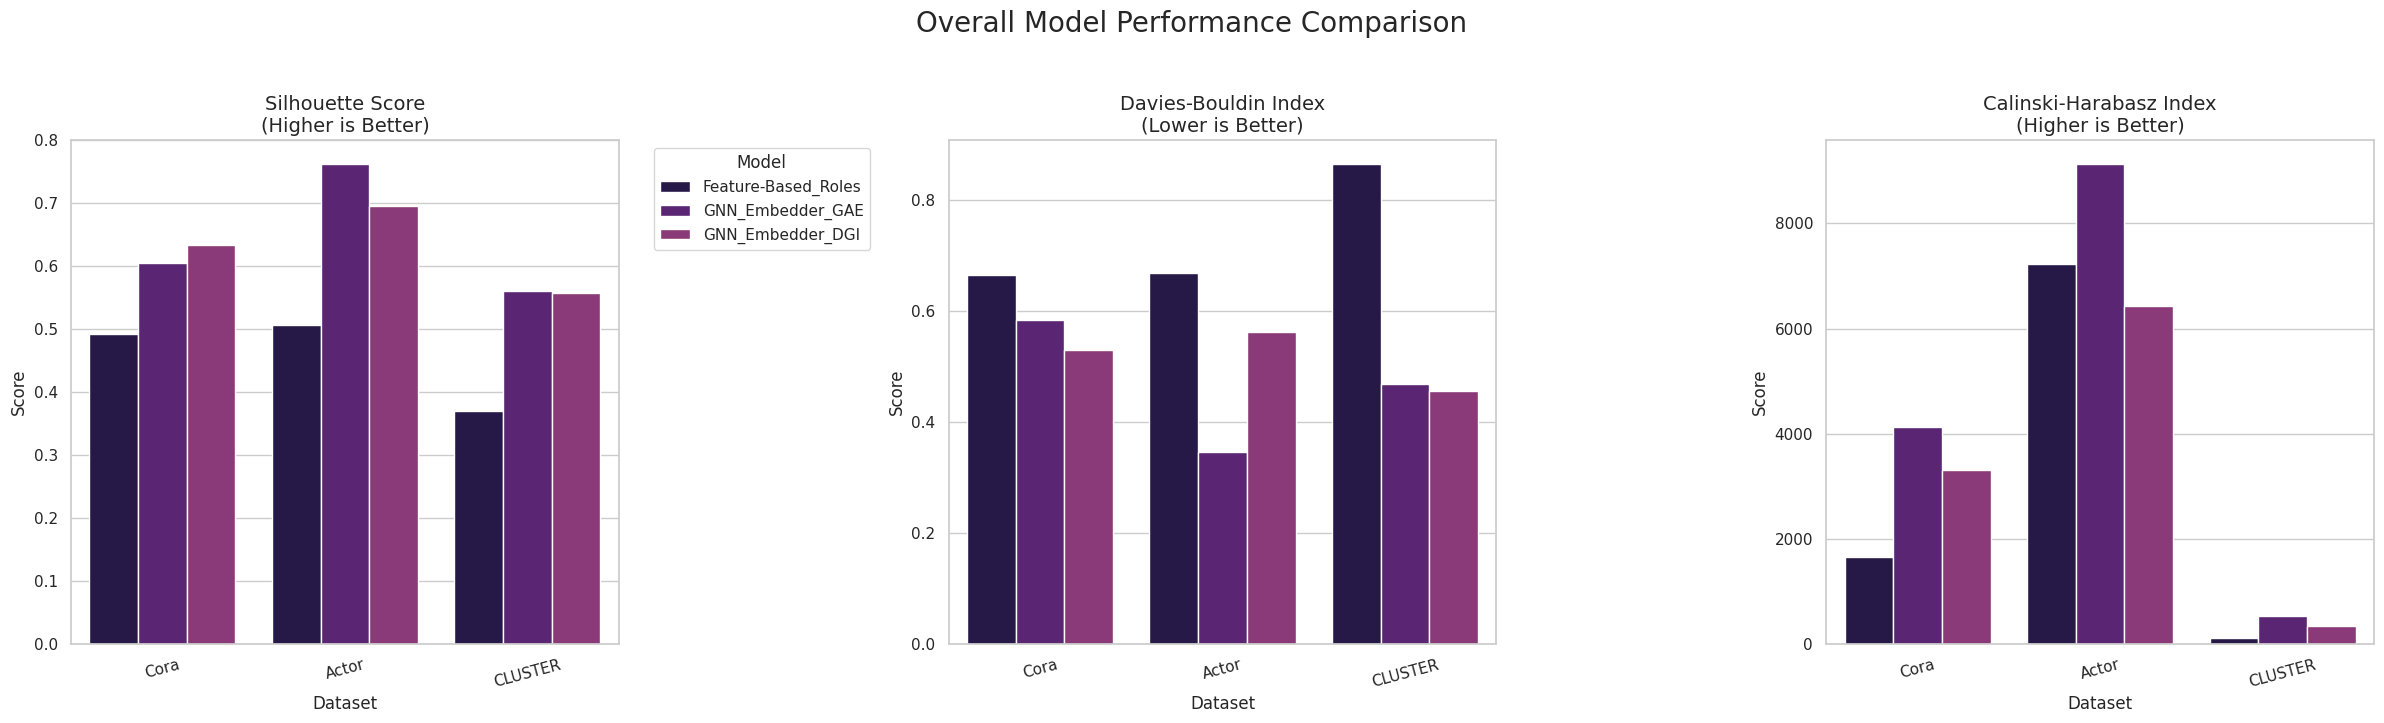

In [3]:
if not summary_df.empty:
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))
    fig.suptitle('Overall Model Performance Comparison', fontsize=20, y=1.03)

    metrics = [("Silhouette Score", "Higher is Better"), 
               ("Davies-Bouldin Index", "Lower is Better"), 
               ("Calinski-Harabasz Index", "Higher is Better")]

    for i, (metric, interpretation) in enumerate(metrics):
        sns.barplot(data=summary_df, x='Dataset', y=metric, hue='Model', ax=axes[i])
        axes[i].set_title(f'{metric}\n({interpretation})', fontsize=14)
        axes[i].set_xlabel("Dataset", fontsize=12)
        axes[i].set_ylabel("Score", fontsize=12)
        axes[i].tick_params(axis='x', rotation=15)
        if i == 0:
            axes[i].legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            axes[i].get_legend().remove()
    
    plt.tight_layout()
    plt.show()

**Interpretation:**
The visualizations clearly show that the GNN-based methods (GAE and DGI) consistently outperform the traditional `Feature-Based_Roles` approach across all datasets and nearly all metrics. Between the two GNN methods, there isn't a single clear winner; their performance is competitive, with GAE slightly ahead expecially for the Actor and cluster datasets.

## 2\. Analysis of the "Actor" Dataset

Now, we perform a analysis on a single dataset to understand the results more deeply. We choose the **Actor** dataset.


### 2.1. Finding the Optimal Number of Roles ($k$)

To select the best number of roles, $k$, for each model, we plot the Silhouette Score against different values of $k$ that were tested. A peak or an "elbow" in the plot suggests an optimal value for $k$.


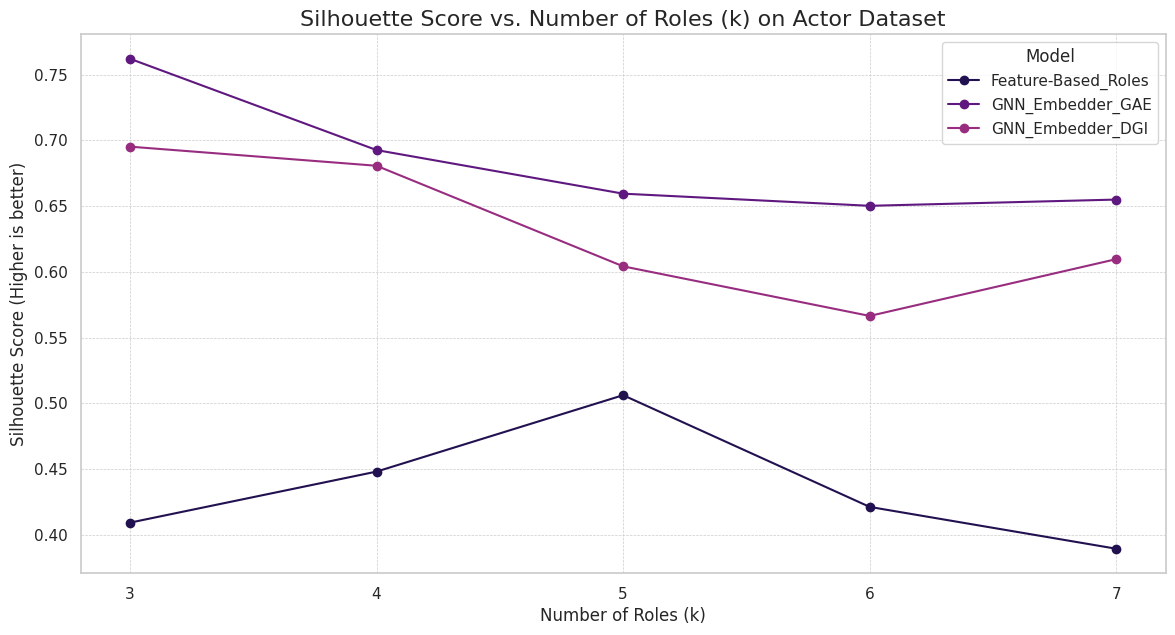

In [4]:
fig, ax = plt.subplots(figsize=(14, 7))

for model_name in MODELS:
    metrics_path = RESULTS_DIR / f"Actor/{model_name}_clustering_metrics.csv"
    if metrics_path.exists():
        df = pd.read_csv(metrics_path)
        ax.plot(df['k'], df['Silhouette Score'], marker='o', linestyle='-', label=model_name)

ax.set_title('Silhouette Score vs. Number of Roles (k) on Actor Dataset', fontsize=16)
ax.set_xlabel('Number of Roles (k)', fontsize=12)
ax.set_ylabel('Silhouette Score (Higher is better)', fontsize=12)
ax.set_xticks(df['k'].unique())
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(title="Model")
plt.show()


**Interpretation:**

For the "Actor" dataset, the GNN models (`GAE` and `DGI`) show their best performance at $k=3$, after which the score begins to decline. This indicates that three is likely the most natural number of distinct structural roles in this graph. The `Feature-Based_Roles` method peaks later at $k=5$, its much lower score implies these groupings are less coherent.

### 2.2. Visualizing the Discovered Roles with t-SNE
t-SNE is a dimensionality reduction technique that allows us to visualize the high-dimensional node embeddings (or feature vectors) in 2D. In a good model, the nodes belonging to the same role should form distinct, well-separated visual clusters.

We will load and display the pre-generated t-SNE plots for the best $k$ value of each model.


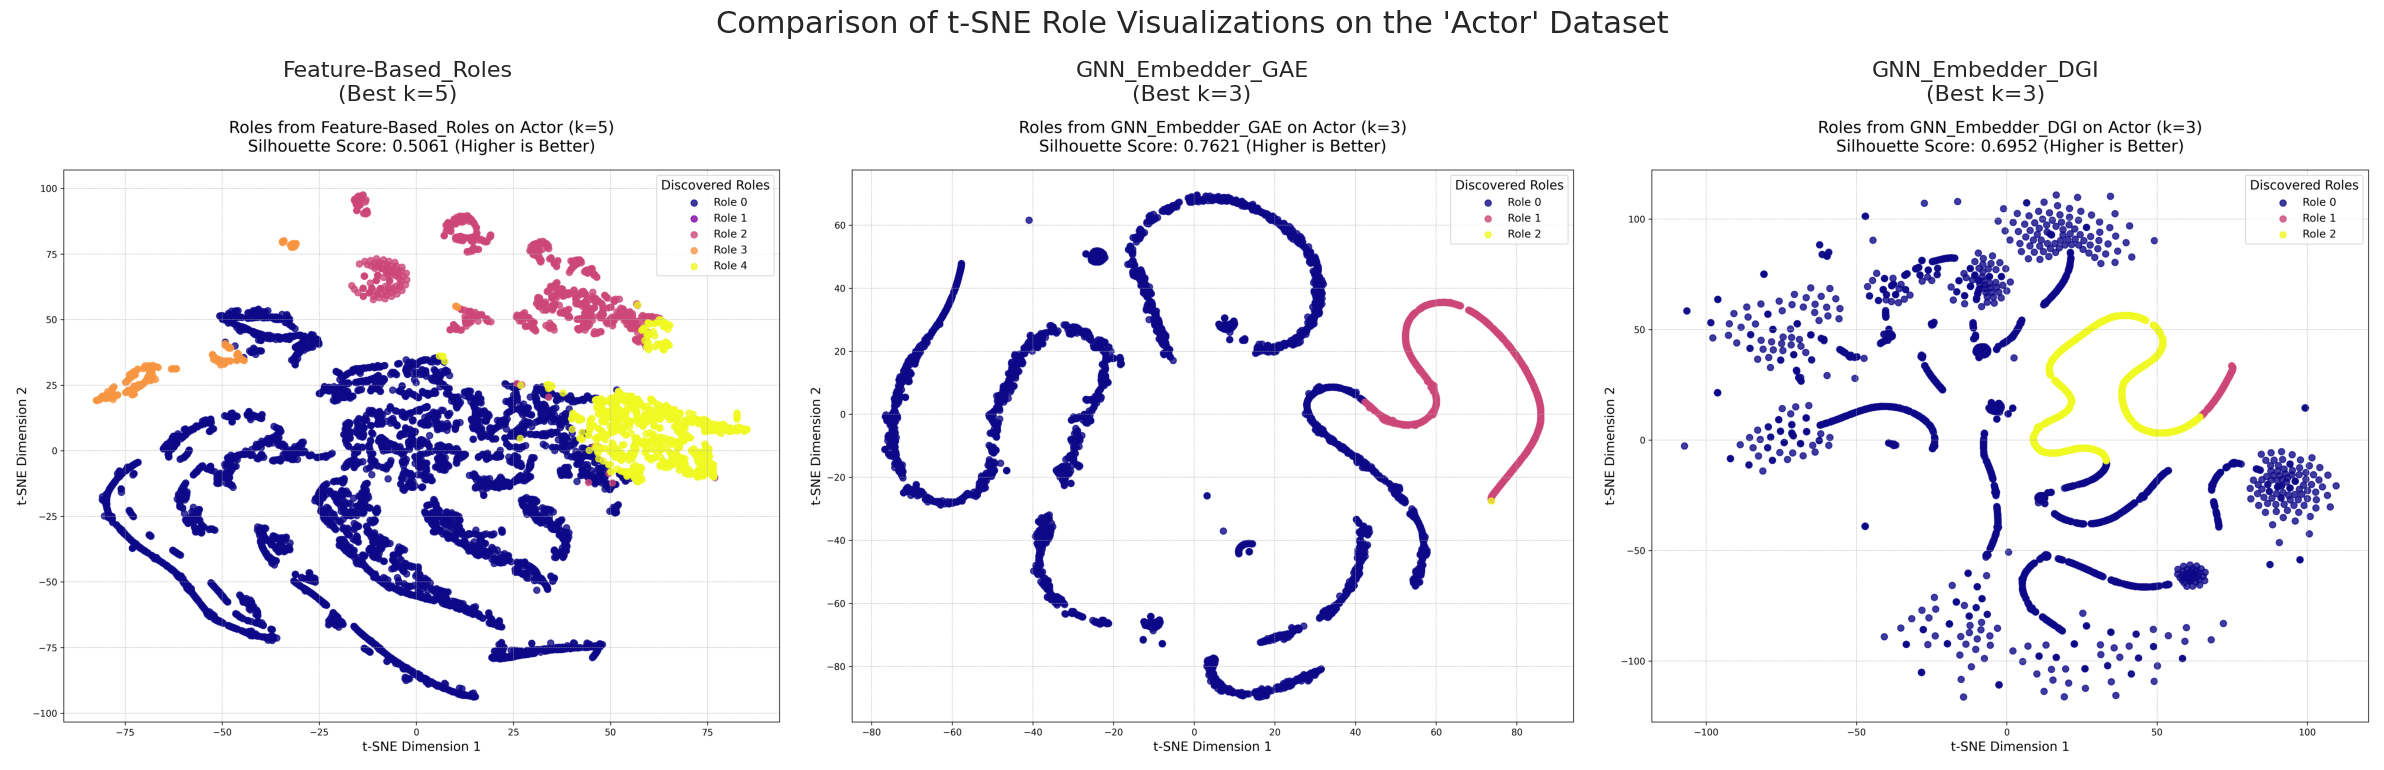

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
import pandas as pd

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle("Comparison of t-SNE Role Visualizations on the 'Actor' Dataset", fontsize=22)

best_k_series = summary_df[summary_df['Dataset'] == 'Actor'].set_index('Model')['Best k']

for ax, model_name in zip(axes.flatten(), MODELS):
    if model_name in best_k_series:
        k = best_k_series[model_name]
        image_path = RESULTS_DIR / f"Actor/{model_name}_k{k}_tsne.png"
        
        ax.set_title(f"{model_name}\n(Best k={k})", fontsize=16, pad=10)
        
        if image_path.exists():
            img = mpimg.imread(image_path)
            ax.imshow(img)
        else:
            ax.text(0.5, 0.5, f'Image not found', ha='center', va='center', fontsize=12)
            
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**Interpretation:** 
The t-SNE visualizations provide strongly reinforcing the quantitative metrics. The `Feature-Based_Roles` model results in a chaotic plot with heavily overlapping and poorly defined clusters, visually explaining its low Silhouette Score. In stark contrast, both the `GNN_Embedder_GAE` and `GNN_Embedder_DGI` models generate remarkably clean plots with distinct, well-separated groups, confirming that their learned embeddings are far more effective for discovering meaningful structural roles.

Comparing the top two methods, the GAE model produces exceptionally sharp, linear structures, while the DGI model forms more globular clusters. Both are excellent representations, but the GAE’s visual separation is slightly crisper, aligning with its higher score. Ultimately, these visualizations provide powerful qualitative proof that the GNNs successfully learned low-dimensional embeddings that effectively capture and separate the distinct structural roles within the Actor network.

### 2.3. Interpreting Role Characteristics
Moving beyond scores and visualizations to understand *what these roles represent*. We load the analysis files, which contain the average structural properties (degree, betweenness, etc.) for nodes within each role. By examining these properties, we can assign intuitive labels.


--- Analysis for Feature-Based_Roles (k=5) ---


,role_id,num_nodes,avg_degree,avg_betweenness,avg_closeness,avg_eigenvector,avg_pagerank,avg_clustering_coeff
0,0,5301,0.000570,0.000133,0.232186,0.000673,0.000092,0.044913
1,1,1,0.171470,0.428559,0.419602,0.676394,0.028033,0.000747
2,2,1169,0.000656,0.000363,0.299532,0.018917,0.000099,0.066865
3,3,285,0.000352,0.000015,0.237221,0.003739,0.000066,0.894876
4,4,844,0.003531,0.001907,0.284393,0.007197,0.000415,0.045230



--- Analysis for GNN_Embedder_GAE (k=3) ---


,role_id,num_nodes,avg_degree,avg_betweenness,avg_closeness,avg_eigenvector,avg_pagerank,avg_clustering_coeff
0,0,6737,0.000599,0.000174,0.244566,0.003967,0.000093,0.085100
1,1,862,0.003288,0.001827,0.279540,0.007069,0.000397,0.041927
2,2,1,0.171470,0.428559,0.419602,0.676394,0.028033,0.000747



--- Analysis for GNN_Embedder_DGI (k=3) ---


,role_id,num_nodes,avg_degree,avg_betweenness,avg_closeness,avg_eigenvector,avg_pagerank,avg_clustering_coeff
0,0,6296,0.000551,0.000145,0.243619,0.003968,0.000087,0.086787
1,1,159,0.007625,0.007202,0.297642,0.016722,0.000937,0.026248
2,2,1145,0.002062,0.000976,0.268888,0.005113,0.000262,0.051425


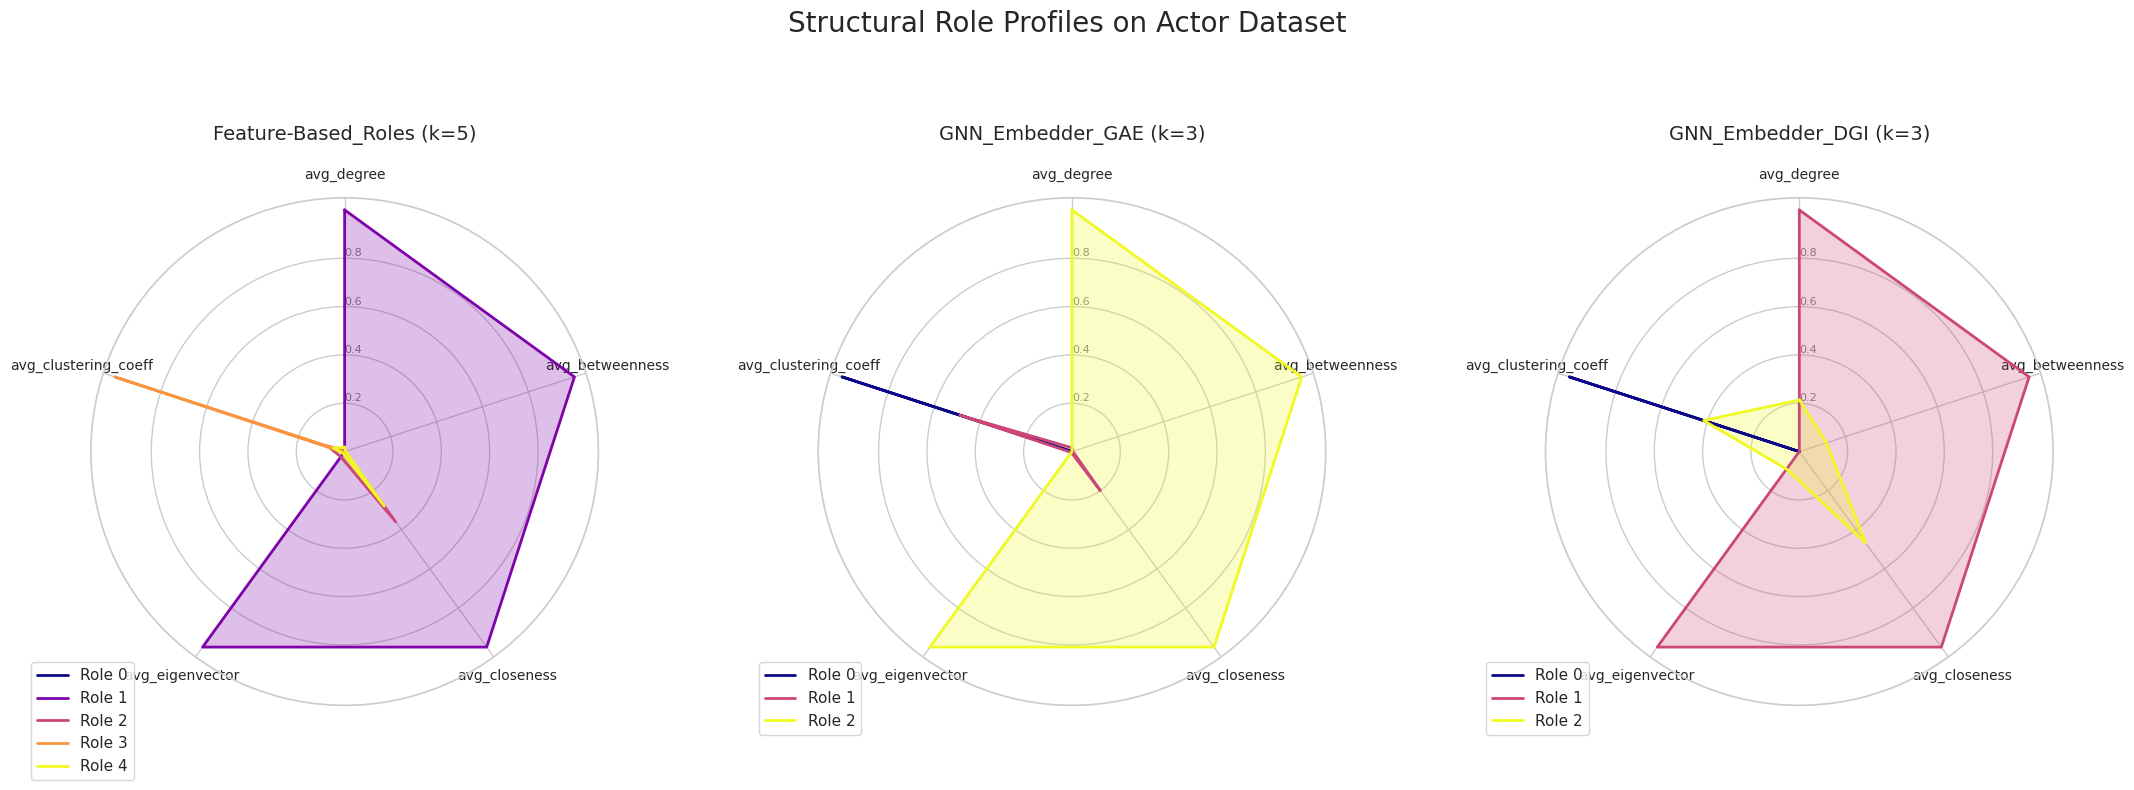

In [6]:
def plot_role_profiles(df, dataset_name, model_name, k, ax):
    metrics_to_plot = ['avg_degree', 'avg_betweenness', 'avg_closeness', 'avg_eigenvector', 'avg_clustering_coeff']
    profiles = df[metrics_to_plot]
    profiles_normalized = (profiles - profiles.min()) / (profiles.max() - profiles.min())
    profiles_normalized = profiles_normalized.fillna(0) 
    
    labels = profiles_normalized.columns
    num_vars = len(labels)
    
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1] 
    
    cmap = plt.get_cmap('plasma')
    colors = cmap(np.linspace(0, 1, len(df)))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1], labels, size=10)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8"], color="grey", size=8)
    
    for i, row in profiles_normalized.iterrows():
        values = row.values.flatten().tolist()
        values += values[:1] 
        ax.plot(angles, values, color=colors[i], linewidth=2, linestyle='solid', label=f"Role {df.at[i, 'role_id']}")
        ax.fill(angles, values, color=colors[i], alpha=0.25)
        
    ax.set_title(f"{model_name} (k={k})", pad=20, fontsize=14)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

fig, axes = plt.subplots(1, 3, figsize=(22, 7), subplot_kw=dict(polar=True))
fig.suptitle('Structural Role Profiles on Actor Dataset', fontsize=20, y=1.1)

for i, model_name in enumerate(MODELS):
    if model_name in best_k_series:
        k = best_k_series[model_name]
        analysis_path = RESULTS_DIR / f"Actor/{model_name}_k{k}_role_analysis.csv"
        if analysis_path.exists():
            role_df = pd.read_csv(analysis_path)
            print(f"\n--- Analysis for {model_name} (k={k}) ---")
            display(role_df)
            plot_role_profiles(role_df, "Actor", model_name, k, axes[i])
        else:
            print(f"Analysis file not found for {model_name}")
            fig.delaxes(axes[i]) 

plt.tight_layout()
plt.show()


**Interpretation of GNN\_Embedder\_GAE (k=3) on Actor:**

Based on the table and the radar chart for the `GNN_Embedder_GAE` model:

  - **Role 0 (Periphery Nodes, \~6737 nodes)**: This is the largest group. It is characterized by extremely low values across all centrality metrics (`avg_degree`, `avg_betweenness`, `avg_closeness`, `avg_eigenvector`). These are the vast majority of actors who are not well-connected and exist on the fringes of the network.
  - **Role 1 (Connectors/Brokers, \~862 nodes)**: This group has moderately high values for `avg_degree` and `avg_betweenness` relative to the periphery. The high betweenness suggests these actors play a crucial role in connecting different parts of the network, acting as bridges or brokers between different communities (e.g., genres or film series).
  - **Role 2 (Super-Hub, 1 node)**: This role contains a single node with exceptionally high values for every single centrality metric. Its `avg_betweenness` and `avg_eigenvector` scores dominate all others. This is the ultimate "hub" of the network, a superstar actor who is not only highly connected but is also connected to other important actors, making them central to the entire graph structure.


### 2.4. Analyzing Role Interactions with Adjacency Matrices

While role profiles tell us about node properties *within* a role, they don't describe how roles connect *to each other*. To analyze this, we compute a **role-to-role adjacency matrix**.

- **Raw Counts Matrix**: The entry `(i, j)` shows the absolute number of edges connecting nodes from role `i` to nodes in role `j`.
- **Normalized Connectivity Matrix**: This matrix is row-normalized by the total degree sum of each role. The entry `(i, j)` represents the proportion of role `i`'s total connections (stubs) that go to role `j`. This reveals preferences:
  - A high diagonal value (`~1.0`) indicates an insular role (a community).
  - High off-diagonal values for a row `i` show it's a "bridge" or "connector" role.



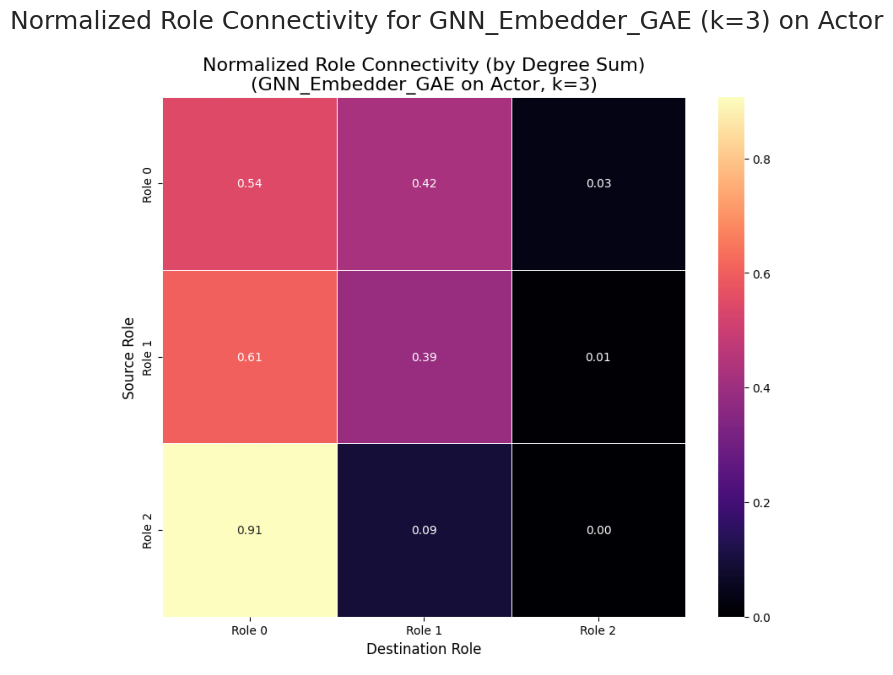

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model_name = 'GNN_Embedder_GAE'
dataset_name = 'Actor'
k = best_k_series.get(model_name)

if k:
    norm_path = RESULTS_DIR / f"{dataset_name}/{model_name}_k{k}_role_adj_heatmap_normalized.png"
    ax.set_title(f"Normalized Role Connectivity for {model_name} (k={k}) on {dataset_name}", fontsize=18, pad=15)
    if norm_path.exists():
        img_norm = mpimg.imread(norm_path)
        ax.imshow(img_norm)
    else:
        ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
    ax.axis('off')
else:
    print(f"Could not find best k for {model_name} on {dataset_name}")
    ax.axis('off')
    
plt.show()

* **Role 2 is a distinct "Super-Hub"**: This role directs almost all of its connections (91%) outward to Role 0 and has virtually no connections to itself or Role 1. This confirms its function as a central hub connecting to the broader network periphery.

* **Role 1 acts as a "Connector/Bridge"**: This role's connections are primarily directed towards Role 0 (61%), with a smaller portion connecting to other nodes within its own role (39%). This pattern is characteristic of a bridging role that links the peripheral nodes (Role 0) together.

* **Role 0 represents the "Periphery"**: These nodes are moderately insular, with a significant number of connections (54%) to other nodes within Role 0, forming local communities. They also connect extensively to the "connector" nodes of Role 1 (42%), which links them to the wider graph structure.

## 3. Bridging Structure and Semantics: Case Study on Cora

So far, our analysis has been purely structural. For datasets with node labels, like Cora, we can take the analysis one step further and investigate whether the structurally-defined roles have a distinct **semantic meaning**. In the Cora dataset, nodes are research papers and the labels (`data.y`) represent the paper's subject area.

Our GNN models discovered roles using only the graph's structure (node degrees), without any knowledge of the paper subjects.

> Does a node's structural role correlate with its academic field?

We will use the best performing model for Cora, `GNN_Embedder_DGI` (k=3), to find out.

In [ ]:
#1. Setup and Data Loading 
import sys
from torch_geometric.datasets import Planetoid
import torch

project_root = str(Path().resolve().parent)
if project_root not in sys.path:
    print(f"Adding project root to path: {project_root}")
    sys.path.append(project_root)

from role_discovery.models.DGIEmbedder import DGIEmbedder
from role_discovery.utils.experiment_utils import clean_params

cora_subject_names = {
    0: 'Theory',
    1: 'Reinforcement_Learning',
    2: 'Genetic_Algorithms',
    3: 'Neural_Networks',
    4: 'Probabilistic_Methods',
    5: 'Case_Based',
    6: 'Rule_Learning'
}

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

In [ ]:
# 2. Load the Best Model and Get Role Assignments 
model_name = "GNN_Embedder_DGI"
dataset_name = "Cora"
best_k = 3

tuning_results_path = RESULTS_DIR / dataset_name / "hyperparameter_tuning_results.csv"
tuning_df = pd.read_csv(tuning_results_path)
dgi_results = tuning_df[tuning_df['model_name'] == model_name]
raw_dgi_params = dgi_results.iloc[0].to_dict()
dgi_params = clean_params({k: v for k, v in raw_dgi_params.items() if k not in ['model_name', 'best_silhouette']})

print(f"Loading best {model_name} with params: {dgi_params}")

model = DGIEmbedder(
    in_channels=data.num_features,
    **dgi_params,
    model_path=str(RESULTS_DIR / dataset_name / f"best_{model_name}_model.pt"),
    force_retrain=False
)

embeddings, role_labels = model.predict(data, k=best_k)
print(f"\nSuccessfully assigned {data.num_nodes} nodes to {best_k} roles.")


Loading best GNN_Embedder_DGI with params: {'lr': 0.001, 'hidden_channels': 256}
DGIEmbedder: Using node degrees as structural features.
Loading pre-trained DGI model from ../results/role_discovery/Cora/best_GNN_Embedder_DGI_model.pt
Embeddings generated from pre-trained DGI model.

Successfully assigned 2708 nodes to 3 roles.


In [21]:
# 3. Analyze and Visualize Subject Distribution per Role 
semantic_df = pd.DataFrame({
    'role_id': role_labels.numpy(),
    'subject_id': data.y.numpy()
})
semantic_df['subject_name'] = semantic_df['subject_id'].map(cora_subject_names)

crosstab = pd.crosstab(semantic_df['role_id'], semantic_df['subject_name'])
crosstab_norm = crosstab.div(crosstab.sum(axis=1), axis=0)

print("\n--- Subject Distribution within Each Structural Role ---")
display(crosstab_norm.style.format("{:.2%}"))



--- Subject Distribution within Each Structural Role ---


subject_name,Case_Based,Genetic_Algorithms,Neural_Networks,Probabilistic_Methods,Reinforcement_Learning,Rule_Learning,Theory
role_id,,,,,,,
0,9.77%,13.68%,38.60%,14.33%,6.68%,5.54%,11.40%
1,11.53%,15.68%,28.12%,16.14%,8.40%,6.98%,13.15%
2,8.55%,20.51%,21.37%,16.24%,8.55%,6.84%,17.95%


Although the GNN model was only given the network structure, the roles it discovered correspond to distinct subject distributions.

Notably, Role 0 is predominantly composed of papers on Neural Networks, while Role 2 has a higher concentration of papers in Genetic Algorithms and Theory. This demonstrates that the model successfully identified that different academic fields create unique structural footprints within the citation graph

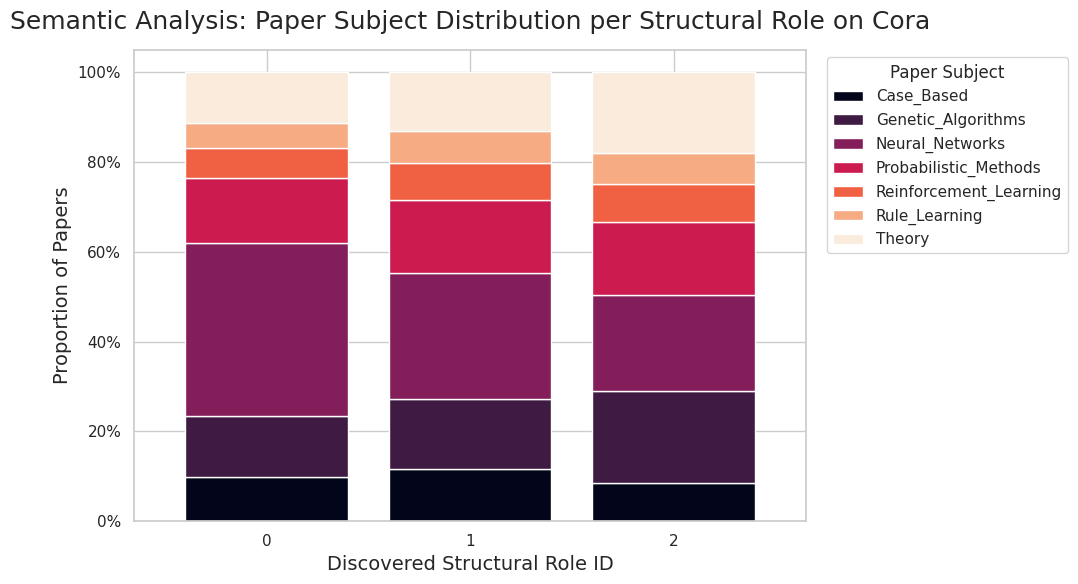

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
crosstab_norm.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    cmap='rocket',
    width=0.8
)

ax.set_title('Semantic Analysis: Paper Subject Distribution per Structural Role on Cora', fontsize=18, pad=15)
ax.set_xlabel('Discovered Structural Role ID', fontsize=14)
ax.set_ylabel('Proportion of Papers', fontsize=14)
ax.tick_params(axis='x', rotation=0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.legend(title='Paper Subject', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.88, 1])
plt.show()

## 3\. Conclusions

The analysis yields several key conclusions:

1.  **GNNs are Superior for Role Discovery**: Both GNN-based methods, GAE and DGI, significantly outperformed the traditional feature-based approach. The learned embeddings capture complex structural patterns that are missed by a hand-picked set of metrics, resulting in more cohesive and well-separated roles.

2.  **Role Interpretability is High**: By analyzing the structural characteristics of the nodes within each GNN-discovered role, we were able to assign meaningful labels like "hub," "broker," and "periphery." This confirms that the unsupervised learning process is identifying functionally relevant node groups.